# Import all the libraries required and cofiguring the GPU

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import math
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

     |████████████████████████████████| 96 kB 5.3 MB/s 
1 Physical GPUs, 1 Logical GPUs


# Import a pre-trained model from keras using the weights from ImageNet

In [5]:
img_width, img_height = 224, 224 #Set the image size
#Check the picture layout
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
#Save the imported model in variable called base_model
base_model=tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet",
)

#Freez the layers in order to not lose the weights
for layer in base_model.layers:
        layer.trainable = False

        

87916544/87910968 [==============================] - 1s 0us/step


# Use Image data generator for data augmentation

In [6]:
train_data_dir = '/content/Training_data_c' #Instantiate the path for dataset 
batch_size = 128 #Set the batch size

#Set the variables for data augmentation
train_datagen = ImageDataGenerator(
       rescale=1./255,
        zoom_range=0.1,
        validation_split=0.2,
        rotation_range=5,
        horizontal_flip=True)
#Apply data augmentation on training set
training_set = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        subset='training',
        class_mode='categorical')
 
#Apply data augmentation on validation set
test_set= train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset='validation',
        shuffle = False,
        class_mode='categorical')
 

test_set.class_indices #Print the classes

Found 227124 images belonging to 7 classes.
Found 56777 images belonging to 7 classes.


{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Add the layers and parameters to the model

In [7]:
num_classes = 7 #Set the number of output neurons
                     
base_input=base_model.layers[0].input #Save the layers of the pre-trained model
base_output=base_model.layers[-1].output #Save the output of the last layer

    
final_output=layers.GlobalMaxPooling2D(data_format='channels_last')(base_output) #Add GlobalMaxPoolig layer
    
final_output=layers.Flatten()(final_output) # Add Flatten layer

final_output=layers.Dense(512)(final_output) #Add fully conected layer with 512 neurons
final_output=tf.keras.layers.ReLU()(final_output) #Add activation function
final_output=layers.Dense(256)(final_output) #Add fully connected layer with 256 neurons
final_output=tf.keras.layers.ReLU()(final_output)#Add activation function

final_output=layers.Dense(num_classes,activation='softmax')(final_output)#Add output layer with neurons for each class


new_model=tf.keras.Model(inputs=base_input,outputs=final_output)#Add the new layers to the model
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])#Compile the model using adam optimizer
new_model.summary()# Print the model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Train the model for ten epochs and save the best weights using ModelCheckpoint

In [8]:
model = new_model
#Create a folder with the best models
directory='/content/drive/MyDrive/Emotion/InceptionV3/Checkpoint_InceptionV3-V6'
name='Model'
saved = os.path.join(directory, name + "-{epoch:02d}.h5")
#Set up the ModelChepoint
callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=saved, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
)
#Train the model
history=model.fit(training_set,
        epochs=10,
        callbacks=callback,
        steps_per_epoch=227124 // batch_size,
        validation_data=test_set,
        validation_steps= 56777 // batch_size)

Epoch 1/10
1774/1774 [==============================] - 3736s 2s/step - loss: 1.4160 - accuracy: 0.5565 - val_loss: 1.1868 - val_accuracy: 0.5687
Epoch 2/10
1774/1774 [==============================] - 3664s 2s/step - loss: 1.1596 - accuracy: 0.5753 - val_loss: 1.1732 - val_accuracy: 0.5745
Epoch 3/10
1774/1774 [==============================] - 3689s 2s/step - loss: 1.1535 - accuracy: 0.5773 - val_loss: 1.1369 - val_accuracy: 0.5812
Epoch 4/10
1774/1774 [==============================] - 3686s 2s/step - loss: 1.1496 - accuracy: 0.5796 - val_loss: 1.1805 - val_accuracy: 0.5772
Epoch 5/10
1774/1774 [==============================] - 3648s 2s/step - loss: 1.1469 - accuracy: 0.5812 - val_loss: 1.1767 - val_accuracy: 0.5774
Epoch 6/10
1774/1774 [==============================] - 3703s 2s/step - loss: 1.1500 - accuracy: 0.5793 - val_loss: 1.1370 - val_accuracy: 0.5838
Epoch 7/10
1774/1774 [==============================] - 3744s 2s/step - loss: 1.1483 - accuracy: 0.5796 - val_loss: 1.1356 -

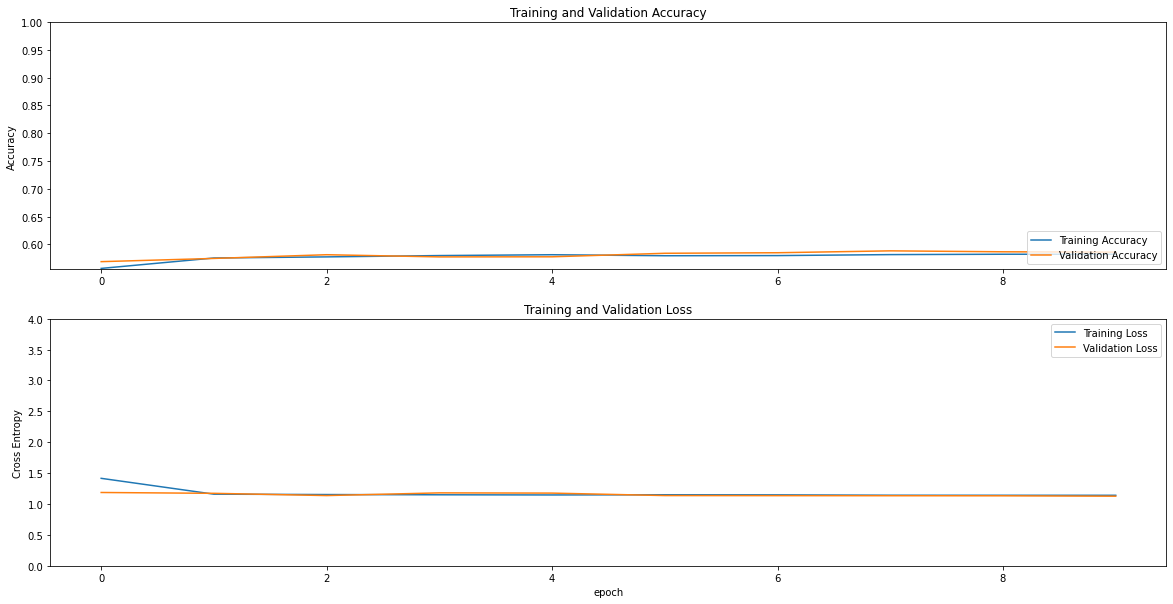

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()